In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [6]:
def collect_data_and_plot(df, test_mode, setting_name, underage_cost):
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path'],
                row['Architecture Class']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        return f"results/one_warehouse_real/{row['# of stores']}/{row['Architecture Class']}/{underage_cost}.csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            while len(futures) >= 24:
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    avg_w_holding = []
    avg_cost = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        data = pd.read_csv(file_name)
        n_samples = 32768
        batch_size = 4096
        num_batches = n_samples // batch_size
        num_steps = 500
        start_step = 300
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * batch_size * num_steps
            step_start = batch_start + start_step * batch_size
            step_end = batch_start + num_steps * batch_size
            relevant_indices.extend(range(step_start, step_end))
        relevant_data = data.iloc[relevant_indices]
        
        n_stores = row['# of stores']
        avg_s_underage.append(relevant_data['s_underage_costs'].mean() / underage_cost)
        avg_s_holding.append(relevant_data['s_holding_costs'].mean() / underage_cost)
        avg_w_holding.append(relevant_data['w_holding_costs'].mean() / underage_cost)
        avg_cost.append(relevant_data['s_underage_costs'].sum() * n_stores + relevant_data['s_holding_costs'].sum() * n_stores + relevant_data['w_holding_costs'].sum())

    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df_copy = df.copy()
    df_copy['avg_s_underage'] = avg_s_underage
    df_copy['avg_s_holding'] = avg_s_holding
    df_copy['avg_w_holding'] = avg_w_holding 
    df_copy['avg_cost'] = avg_cost
    df = df_copy

    # Calculate relative cost
    # Calculate cost as percentage of lowest cost
    # Calculate min cost for each number of stores
    df['cost'] = df.groupby('# of stores')['avg_cost'].transform(lambda x: x/x.min() * 100)

    plot_data = df.pivot(index="# of stores", columns='Architecture Class', 
                         values=['cost', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding'])
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration
    titles = ['Cost (% of minimum at each # of stores)', 'Average Store lost sales / (average unit underage cost)', 'Average Store Holding Cost / (average unit underage cost)', 'Average Warehouse Holding Cost / (average unit underage cost)']
    y_values = ['cost', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding']

    x_values = df['# of stores'].unique()
    for i, (ax, title, y_value) in enumerate(zip(axes, titles, y_values)):
        for arch in df['Architecture Class'].unique():
            if arch == 'Just_In_Time':
                continue
            if arch in plot_data[y_value].columns:
                ax.plot(x_values, plot_data[y_value][arch].loc[x_values], marker='o', label=f'{arch}', 
                        color=color_scheme[arch], linestyle=linestyle_scheme[arch])
        
        ax.set_xlabel('Number of stores')
        ax.set_ylabel(f'{title}')
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
        ax.set_xticks(x_values)
        ax.set_xticklabels(x_values)
    
    plt.tight_layout()
    plt.show()
    return df


   # of stores Architecture Class  Train Loss  Dev Loss  Test Loss  Test Gap %  Mean Test Loss  Test Loss Variance
0            3             GNN_MP    5.659300  5.650246   5.650508    0.722072        5.650508                 NaN
1            3       paper_result         NaN       NaN   5.610000    0.000000        5.610000                 NaN
2            5       paper_result         NaN       NaN   5.240000    0.000000        5.240000                 NaN
3           10             GNN_MP    5.752826  5.795088   5.756624    0.816533        5.756624                 NaN
4           10       paper_result         NaN       NaN   5.710000    0.000000        5.710000                 NaN
5           20       paper_result         NaN       NaN   5.820000    0.000000        5.820000                 NaN
6           30       paper_result         NaN       NaN   5.550000    0.000000        5.550000                 NaN
7           50             GNN_MP    5.591668  5.574483   5.589870    4.288618  

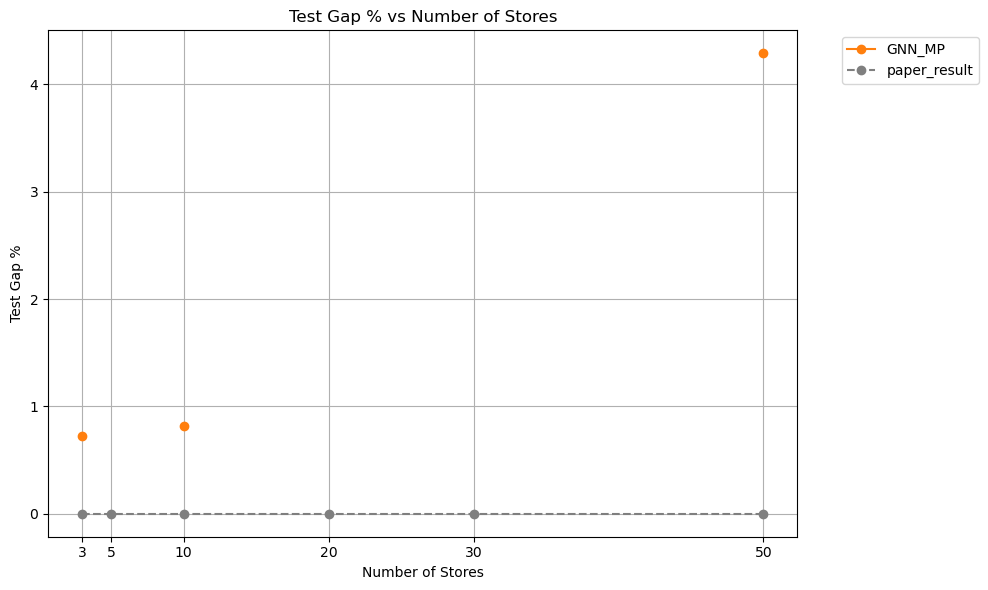

In [7]:
# Define color scheme for architecture types
color_scheme = {
    "GNN_MP": "#ff7f0e",  # Orange
    "paper_result": "#7f7f7f"  # Gray
}

linestyle_scheme = {
    "GNN_MP": "-",  # Solid
    "paper_result": "--"  # Dashed
}

testset_name = "generic_architecture"
gnn_mp_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP/3',
    # 5: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP/5',
    10: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP/10',
    # 20: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP/20',
    # 30: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP/30',
    50: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP/50'
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'test_loss'
pick_row_from_run_by = 'test_loss'

results_interpretor = rri.RayResultsinterpreter()

# GNN MP
df_gnn_mp = results_interpretor.make_table(gnn_mp_paths,
    {'samples': [1,2,3]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp.insert(2, 'Architecture Class', "GNN_MP")
df_gnn_mp.insert(1, 'hyperparam_name', "GNN_MP")

# Create paper results dataframe
paper_data = []
for n_stores, test_loss in {3: 5.61, 5: 5.24, 10: 5.71, 20: 5.82, 30: 5.55, 50: 5.36}.items():
    row = {
        '# of stores': n_stores,
        'Architecture Class': 'paper_result',
        'Test Loss': test_loss
    }
    paper_data.append(row)
df_paper = pd.DataFrame(paper_data)

# Combine dataframes
df = pd.concat([
    df_gnn_mp,
    df_paper
])

min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores'], inplace=True)
# Move '# of runs' column to the end
if '# of runs' in df.columns:
    runs_col = df.pop('# of runs')
    df['# of runs'] = runs_col

df_to_print = df.copy()
# Calculate mean and variance of test loss grouped by # of stores and architecture class
variance_df = df_to_print.groupby(['# of stores', 'Architecture Class'])['Test Loss'].agg(['mean', 'var']).reset_index()
variance_df.columns = ['# of stores', 'Architecture Class', 'Mean Test Loss', 'Test Loss Variance']

# Round variance to 6 decimal places
variance_df['Test Loss Variance'] = variance_df['Test Loss Variance'].round(6)
variance_df['Mean Test Loss'] = variance_df['Mean Test Loss'].round(6)

# Merge mean and variance back into main dataframe
df_to_print = df_to_print.merge(
    variance_df[['# of stores', 'Architecture Class', 'Mean Test Loss', 'Test Loss Variance']], 
    on=['# of stores', 'Architecture Class'],
    how='left'
)

# Keep only the row with minimum test loss for each combination of '# of stores' and 'Architecture Class'
df_to_print = df_to_print.loc[df_to_print.groupby(['# of stores', 'Architecture Class'])['Test Loss'].idxmin()]

columns_to_drop = ['path', 'samples', 'Learning Rate', 'include_context_for_warehouse_input', '# of runs', 'hyperparam_name', 'store_orders_for_warehouse']
df_to_print.drop(columns=[col for col in columns_to_drop if col in df_to_print.columns], inplace=True)
print(df_to_print.to_string())

# Create single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create pivot table
pivot_df = df.groupby(['# of stores', 'Architecture Class'])['Test Gap %'].min().unstack()

# Plot lines for each architecture
for column in pivot_df.columns:
    ax.plot(pivot_df.index.to_numpy(), pivot_df[column].to_numpy(),
            marker='o',
            label=column, 
            color=color_scheme[column],
            linestyle=linestyle_scheme[column])

ax.set_xlabel('Number of Stores')
ax.set_ylabel('Test Gap %')
ax.set_title('Test Gap % vs Number of Stores')
ax.grid(True)
ax.set_xticks(pivot_df.index)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

   # of stores      Architecture Class  Train Loss  Dev Loss  Test Loss  Test Gap %  Mean Test Loss  Test Loss Variance
3            3  GNN_MP_merged_residual    5.616457  5.616076   5.608620    0.000000        5.609196            0.000000
1            3          Symmetry_Aware    5.613299  5.618869   5.611474    0.050891        5.611976            0.000000
9           50  GNN_MP_merged_residual    5.342555  5.344252   5.341442    0.000000        5.416548            0.012022
6           50          Symmetry_Aware    5.358767  5.356499   5.356091    0.274263        5.366308            0.000078


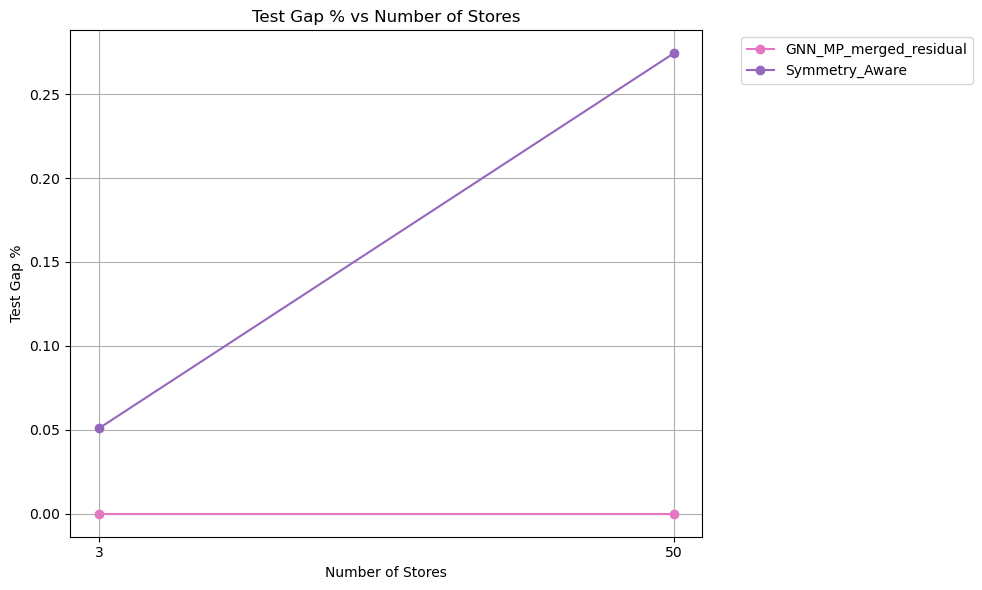

In [4]:
# Define color scheme for architecture types
color_scheme = {
    "Symmetry_Aware": "#9467bd",  # Purple
    "GNN_MP": "#ff7f0e",  # Orange
    "GNN_MP_NN_Per_Layer": "#2ca02c",  # Green
    "GNN_MP_merged": "#1f77b4",  # Blue
    "GNN_MP_merged_attention": "#d62728",  # Red
    "GNN_MP_merged_pna": "#8c564b",  # Brown
    "GNN_MP_NN_Per_Layer_merged_residual": "#17becf",  # Cyan
    "GNN_MP_merged_residual": "#e377c2",  # Pink
}

linestyle_scheme = {
    "Symmetry_Aware": "-",  # Solid
    "GNN_MP": "-",  # Solid
    "GNN_MP_NN_Per_Layer": "-",  # Solid
    "GNN_MP_merged": "-",  # Solid
    "GNN_MP_merged_attention": "-",  # Solid
    "GNN_MP_merged_pna": "-",  # Solid
    "GNN_MP_NN_Per_Layer_merged_residual": "-",  # Solid
    "GNN_MP_merged_residual": "-",  # Solid
}

testset_name = "generic_architecture"
symmetry_aware_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/symmetry_aware/3',
    50: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/symmetry_aware/50'
}
gnn_mp_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP/3', 
    50: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP/50'
}
gnn_mp_nn_per_layer_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_NN_Per_Layer/3',
    50: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_NN_Per_Layer/50'
}
gnn_mp_merged_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_merged/3',
    50: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_merged/50'
}
gnn_mp_merged_attention_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_merged_attention/3',
    50: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_merged_attention/50'
}
gnn_mp_merged_pna_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_merged_pna/3',
    50: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_merged_pna/50'
}
gnn_mp_nn_per_layer_merged_residual_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_NN_Per_Layer_merged_residual/3',
    50: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_NN_Per_Layer_merged_residual/50'
}
gnn_mp_merged_residual_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_merged_residual/3',
    50: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_merged_residual/50'
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'test_loss'
pick_row_from_run_by = 'test_loss'

results_interpretor = rri.RayResultsinterpreter()

# Symmetry aware
df_symmetry_aware = results_interpretor.make_table(symmetry_aware_paths,
    {'store_orders_for_warehouse': False, 'samples': [1,2,3]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_symmetry_aware.insert(2, 'Architecture Class', "Symmetry_Aware")
df_symmetry_aware.insert(1, 'hyperparam_name', "symmetry_aware")

# GNN MP
df_gnn_mp = results_interpretor.make_table(gnn_mp_paths,
    {'samples': [1,2,3]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp.insert(2, 'Architecture Class', "GNN_MP")
df_gnn_mp.insert(1, 'hyperparam_name', "GNN_MP")

# GNN MP NN Per Layer
df_gnn_mp_nn_per_layer = results_interpretor.make_table(gnn_mp_nn_per_layer_paths,
    {'samples': [1,2,3]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp_nn_per_layer.insert(2, 'Architecture Class', "GNN_MP_NN_Per_Layer")
df_gnn_mp_nn_per_layer.insert(1, 'hyperparam_name', "GNN_MP_NN_Per_Layer")

# GNN MP merged
df_gnn_mp_merged = results_interpretor.make_table(gnn_mp_merged_paths,
    {'samples': [1,2,3]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp_merged.insert(2, 'Architecture Class', "GNN_MP_merged")
df_gnn_mp_merged.insert(1, 'hyperparam_name', "GNN_MP_merged")

# GNN MP merged attention
df_gnn_mp_merged_attention = results_interpretor.make_table(gnn_mp_merged_attention_paths,
    {'samples': [1,2,3]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp_merged_attention.insert(2, 'Architecture Class', "GNN_MP_merged_attention")
df_gnn_mp_merged_attention.insert(1, 'hyperparam_name', "GNN_MP_merged_attention")

# GNN MP merged pna
df_gnn_mp_merged_pna = results_interpretor.make_table(gnn_mp_merged_pna_paths,
    {'samples': [1,2,3]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp_merged_pna.insert(2, 'Architecture Class', "GNN_MP_merged_pna")
df_gnn_mp_merged_pna.insert(1, 'hyperparam_name', "GNN_MP_merged_pna")

# GNN MP NN Per Layer merged residual
df_gnn_mp_nn_per_layer_merged_residual = results_interpretor.make_table(gnn_mp_nn_per_layer_merged_residual_paths,
    {'samples': [1,2,3]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp_nn_per_layer_merged_residual.insert(2, 'Architecture Class', "GNN_MP_NN_Per_Layer_merged_residual")
df_gnn_mp_nn_per_layer_merged_residual.insert(1, 'hyperparam_name', "GNN_MP_NN_Per_Layer_merged_residual")

# GNN MP merged residual
df_gnn_mp_merged_residual = results_interpretor.make_table(gnn_mp_merged_residual_paths,
    {'samples': [1,2,3]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp_merged_residual.insert(2, 'Architecture Class', "GNN_MP_merged_residual")
df_gnn_mp_merged_residual.insert(1, 'hyperparam_name', "GNN_MP_merged_residual")

# Combine dataframes
df = pd.concat([
    df_symmetry_aware,
    #df_gnn_mp,
    # df_gnn_mp_nn_per_layer,
    df_gnn_mp_merged,
    #df_gnn_mp_merged_attention,
    #df_gnn_mp_merged_pna,
    # df_gnn_mp_nn_per_layer_merged_residual,
    df_gnn_mp_merged_residual
])

min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores'], inplace=True)
# Move '# of runs' column to the end
if '# of runs' in df.columns:
    runs_col = df.pop('# of runs')
    df['# of runs'] = runs_col

df_to_print = df.copy()
# Calculate mean and variance of test loss grouped by # of stores and architecture class
variance_df = df_to_print.groupby(['# of stores', 'Architecture Class'])['Test Loss'].agg(['mean', 'var']).reset_index()
variance_df.columns = ['# of stores', 'Architecture Class', 'Mean Test Loss', 'Test Loss Variance']

# Round variance to 6 decimal places
variance_df['Test Loss Variance'] = variance_df['Test Loss Variance'].round(6)
variance_df['Mean Test Loss'] = variance_df['Mean Test Loss'].round(6)

# Merge mean and variance back into main dataframe
df_to_print = df_to_print.merge(
    variance_df[['# of stores', 'Architecture Class', 'Mean Test Loss', 'Test Loss Variance']], 
    on=['# of stores', 'Architecture Class'],
    how='left'
)

# Keep only the row with minimum test loss for each combination of '# of stores' and 'Architecture Class'
df_to_print = df_to_print.loc[df_to_print.groupby(['# of stores', 'Architecture Class'])['Test Loss'].idxmin()]

columns_to_drop = ['path', 'samples', 'Learning Rate', 'include_context_for_warehouse_input', '# of runs', 'hyperparam_name', 'store_orders_for_warehouse']
df_to_print.drop(columns=[col for col in columns_to_drop if col in df_to_print.columns], inplace=True)
print(df_to_print.to_string())

# Create single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create pivot table
pivot_df = df.groupby(['# of stores', 'Architecture Class'])['Test Gap %'].min().unstack()

# Plot lines for each architecture
for column in pivot_df.columns:
    ax.plot(pivot_df.index.to_numpy(), pivot_df[column].to_numpy(),
            marker='o',
            label=column, 
            color=color_scheme[column],
            linestyle=linestyle_scheme[column])

ax.set_xlabel('Number of Stores')
ax.set_ylabel('Test Gap %')
ax.set_title('Test Gap % vs Number of Stores')
ax.grid(True)
ax.set_xticks(pivot_df.index)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [17]:
df_t = collect_data_and_plot(df, "test", "one_warehouse_lost_demand_exp_underage_cost_random_yield", 1)